## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.7.0+cpu'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

The data we're going to be using is a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/).

Food101 is popular computer vision benchmark as it contains 1000 images of 101 different kinds of foods, totaling 101,000 images (75,750 train and 25,250 test).

Instead of 101 food classes though, we're going to start with 3: tacos, breakfast_burritos and ravioli.

And instead of 1,000 images per class, we're going to start with a random 10%.


In [3]:
# Dwonlaod data from Github
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "tacos_breakfast_burritos_ravioli"
zip_file_path = data_path / "tacos_breakfast_burrito_ravioli_10_percent.zip" # Define the path for the zip file

# If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download tacos, breakfast_burritos, ravioli
    # Save the downloaded content to the zip file path, not the directory path
    with open(zip_file_path, "wb") as f:
        # Changed the URL to the raw file link
        request = requests.get("https://github.com/matmarcinek/Food-Image-Classification-using-Deep-Learning/blob/main/data/tacos_breakfast_burrito_ravioli_10_percent.zip")
        print("Downloading tacos, breakfast_burritos,ravioli data...")
        f.write(request.content)

    # Unzip tacos, breakfast_burritos, ravioli data
    # Unzip the downloaded zip file into the image_path directory
    with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
        print("Unzipping tacos, breakfast_burritos, ravioli data...")
        zip_ref.extractall(image_path)


Did not find data\tacos_breakfast_burritos_ravioli directory, creating one...
Unzipping tacos, breakfast_burritos, ravioli data...


## 2.Data preparation

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\tacos_breakfast_burritos_ravioli'.
There are 3 directories and 0 images in 'data\tacos_breakfast_burritos_ravioli\test'.
There are 0 directories and 25 images in 'data\tacos_breakfast_burritos_ravioli\test\breakfast_burrito'.
There are 0 directories and 19 images in 'data\tacos_breakfast_burritos_ravioli\test\ravioli'.
There are 0 directories and 31 images in 'data\tacos_breakfast_burritos_ravioli\test\tacos'.
There are 3 directories and 0 images in 'data\tacos_breakfast_burritos_ravioli\train'.
There are 0 directories and 78 images in 'data\tacos_breakfast_burritos_ravioli\train\breakfast_burrito'.
There are 0 directories and 75 images in 'data\tacos_breakfast_burritos_ravioli\train\ravioli'.
There are 0 directories and 72 images in 'data\tacos_breakfast_burritos_ravioli\train\tacos'.



There are about 75 images per training class and 25 images per testing class.

That should be enough to get started.

These images are just subsets of the original Food101 dataset.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/tacos_breakfast_burritos_ravioli/train'),
 WindowsPath('data/tacos_breakfast_burritos_ravioli/test'))

### 2.1 Visualize an image

Random image path: data\tacos_breakfast_burritos_ravioli\test\tacos\2377562.jpg
Image class: tacos
Image height: 341
Image width: 512


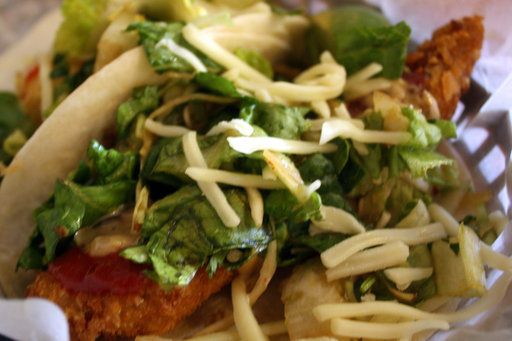

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths 
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name 
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)



## 3. Transforming data

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

## 4. Option 1: Loading Image Data Using [`ImageFolder`]

In [11]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\tacos_breakfast_burritos_ravioli\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\tacos_breakfast_burritos_ravioli\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [12]:
# Get class names as a list
class_names = train_data.classes
class_names

['breakfast_burrito', 'ravioli', 'tacos']

In [13]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'breakfast_burrito': 0, 'ravioli': 1, 'tacos': 2}

In [14]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [15]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.2039, 0.2353, 0.2471,  ..., 0.6784, 0.7098, 0.7451],
         [0.7608, 0.7608, 0.7647,  ..., 0.7020, 0.7255, 0.7451],
         [0.8431, 0.8549, 0.8510,  ..., 0.7137, 0.7176, 0.7294],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.9647, 0.9725, 0.9843],
         [0.0078, 0.0078, 0.0039,  ..., 0.9843, 0.9843, 0.9843],
         [0.0157, 0.0078, 0.0039,  ..., 0.9882, 0.9804, 0.9804]],

        [[0.2275, 0.2510, 0.2706,  ..., 0.7451, 0.7686, 0.8000],
         [0.8078, 0.8157, 0.8157,  ..., 0.7569, 0.7765, 0.7922],
         [0.8745, 0.8941, 0.8902,  ..., 0.7608, 0.7686, 0.7804],
         ...,
         [0.0039, 0.0039, 0.0039,  ..., 0.9686, 0.9804, 0.9922],
         [0.0078, 0.0078, 0.0039,  ..., 0.9922, 0.9961, 0.9961],
         [0.0157, 0.0078, 0.0039,  ..., 0.9961, 1.0000, 1.0000]],

        [[0.1922, 0.2196, 0.2392,  ..., 0.8078, 0.8353, 0.8745],
         [0.7412, 0.7451, 0.7490,  ..., 0.8196, 0.8392, 0.8627],
         [0.8039, 0.8196, 0.8235,  ..., 0.82

In [1]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

NameError: name 'img' is not defined

### 4.1 Turn loaded images into `DataLoader`'s

In [2]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

NameError: name 'train_data' is not defined

In [ ]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

### 5.1 Creating a helper function to get class names

In [ ]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Excellent!

How about we turn it into a full function?

In [ ]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Crearte a dictionary of index labels 
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

In [ ]:
find_classes(train_dir)

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [ ]:
# Write a custom dataset class 
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

    # 2. Initialize with a targ_dir and transform 
    def __init__(self, targ_dir: str, transform=None) -> None:

        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) 
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    # 5. Overwrite the __len__() method 
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    # 6. Overwrite the __getitem__() method 
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name 
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx # return data, label (X, y)

In [ ]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [ ]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)
train_data_custom, test_data_custom

In [ ]:
len(train_data_custom), len(test_data_custom)

In [ ]:
train_data_custom.classes

In [ ]:
train_data_custom.class_to_idx

In [ ]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

### 5.3 Create a function to display random images

In [ ]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: 
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

In [ ]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

In [ ]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

### 5.4 Turn custom loaded images into `DataLoader`'s

In [ ]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=1, 
                                     num_workers=0, 
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

In [ ]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

In [ ]:
# Data augmentation 
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

## 6. Model 0: TinyVGG without data augmentation

### 6.1 Creating transforms and loading data for Model 0

In [ ]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

In [ ]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

### 6.2 Create TinyVGG model class

In [ ]:
import torch
import torch.nn as nn  # Import the nn module from PyTorch

# First, define the device
import torch

# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Then use the device with your model
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, 
                      stride=1, 
                      padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) 
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

### 6.3 Test the model

In [ ]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out 
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

### 6.4 Use `torchinfo`



In [ ]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

### 6.5 Create train & test loop functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### 6.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### 6.7 Train and Evaluate Model 0

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, 
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer 
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

### 6.8 Plot the loss curves of Model 0

In [ ]:
# Check the model_0_results keys
model_0_results.keys()

In [ ]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [ ]:
plot_loss_curves(model_0_results)

## 7. Model results

In [ ]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

In [ ]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 8. Make a prediction on a custom image

In [ ]:
# Download custom image
import requests
from pathlib import Path

# Setup custom image path
data_path = Path("data/") 
custom_image_path = data_path / "1220708.jpg" 

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        # Changed the URL to the raw file link
        request = requests.get("https://github.com/matmarcinek/Food-Image-Classification-using-Deep-Learning/blob/main/data/1220708.jpg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

### 8.1 Loading in a custom image with PyTorch

In [ ]:
import torchvision
from PIL import Image
from torchvision import transforms

# Read in custom image using PIL
try:
    img_pil = Image.open(custom_image_path)
    print(f"Custom image read successfully using PIL: {custom_image_path}")

    # Define a simple transform to convert PIL Image to PyTorch Tensor
    to_tensor_transform = transforms.ToTensor()

    # Apply the transform
    custom_image_tensor = to_tensor_transform(img_pil)

    # Print out image data
    print(f"Custom image tensor:\n{custom_image_tensor}\n")
    print(f"Custom image shape: {custom_image_tensor.shape}\n")
    print(f"Custom image dtype: {custom_image_tensor.dtype}")

except Exception as e:
    print(f"Could not read image using PIL: {e}")
    print("Please check the image file to ensure it is a valid image format.")

In [ ]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

### 8.2 Predicting on custom images with a trained PyTorch model

In [ ]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) 
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [ ]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

In [ ]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

In [ ]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

In [ ]:
custom_image_pred

In [ ]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities 
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

In [ ]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] 
custom_image_pred_class

In [ ]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

### 8.3 Putting custom image prediction together: building a function

In [ ]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities 
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image 
    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

In [ ]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Things to remember

1. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8`.
2. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.
3. **Wrong devices** - Your model is on the GPU but your data is on the CPU.